<a href="https://colab.research.google.com/github/surpha/mVQA/blob/main/conquer/Multilingual_x_CLIP_Implementation_Original_Codebase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import subprocess
CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = ""
else:
    torch_version_suffix = "+cu110"

CUDA version: 12.2


In [5]:
!pip install torch torchvision -f https://download.pytorch.org/whl/torch_stable.html ftfy regex
!pip install ftfy==5.8
!pip install transformers

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 39.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 67.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 76.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [6]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os, random
import torch

In [7]:
!pip install git+https://github.com/openai/CLIP.git
import clip

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-wnkz26wo
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-wnkz26wo
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369499 sha256=f37a7b5112e5fedb4c1e17c70b20226abe1f3a1d7933460e86b1d5bbf8a24c4f
  Stored in directory: /tmp/pip-ephem-wheel-cache-9obwjaxt/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [8]:
!git clone https://github.com/FreddeFrallan/Multilingual-CLIP
%cd Multilingual-CLIP
# !bash get-weights.sh

Cloning into 'Multilingual-CLIP'...
remote: Enumerating objects: 663, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 663 (delta 64), reused 60 (delta 43), pack-reused 560
Receiving objects: 100% (663/663), 8.00 MiB | 14.82 MiB/s, done.
Resolving deltas: 100% (335/335), done.
/content/Multilingual-CLIP
bash: get-weights.sh: No such file or directory


In [9]:
%ls

 HISTORY.md             legacy_get-weights.sh  'Model Cards'/             requirements.txt
 Images/                legacy_inference.py     multilingual_clip/        setup.py
 inference_example.py   LICENSE                 Multilingual_CLIP.ipynb   translation/
 larger_mclip.md        Makefile                README.md


In [10]:
!bash legacy_get-weights.sh

--2024-04-01 08:59:26--  https://www.dropbox.com/s/s77xw5308jeljlp/Swedish-500k%20Linear%20Weights.pkl
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/s77xw5308jeljlp/Swedish-500k%20Linear%20Weights.pkl [following]
--2024-04-01 08:59:26--  https://www.dropbox.com/s/raw/s77xw5308jeljlp/Swedish-500k%20Linear%20Weights.pkl
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7f7727c429f7f6f7351edd74c2.dl.dropboxusercontent.com/cd/0/inline/CQI1hosRVKVIUfhLEKU58TZGsrNIVhVXeEFxVNJb12Isz2muR__CkHvinSzV69WJxSdOXhefHJjJad69PLKD9laAWFee8Kxe2hR3rof3ugrJeAi7GIolUicTUvLUZzGq6JAGKQUIzYy3G5ZR6YogMMIX/file# [following]
--2024-04-01 08:59:26--  https://uc7f7727c429f7f6f7351edd74c2.dl.dropboxusercontent.com/cd/0/inline/CQI1hosRVKVIUfhLEKU58TZGsrNIVhVXe

Loading the text encoder

In [13]:
%ls

 data/                  larger_mclip.md         Makefile                  README.md
 HISTORY.md             legacy_get-weights.sh  'Model Cards'/             requirements.txt
 Images/                legacy_inference.py     multilingual_clip/        setup.py
 inference_example.py   LICENSE                 Multilingual_CLIP.ipynb   translation/


In [15]:
from multilingual_clip import legacy_multilingual_clip
text_model = legacy_multilingual_clip.load_model('M-BERT-Distil-40')

# M BERT Distil-40

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/270 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/514 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/539M [00:00<?, ?B/s]

Load matching CLIP model

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda
cuda


In [22]:
## Outdated, updated after reading documentation

# clip_model, compose = clip.load('RN50x4', device)
# # The model 'RN50x4' refers to a ResNet-50 backbone architecture with 4x the number of tokens in the output embedding compared to the original CLIP model.
# input_resolution = clip_model.input_resolution.item()
# context_length = clip_model.context_length.item()
# vocab_size = clip_model.vocab_size.item()

# print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in clip_model.parameters()]):,}")
# print("Input resolution:", input_resolution)
# print("Context length:", context_length)
# print("Vocab size:", vocab_size)

AttributeError: 'CLIP' object has no attribute 'input_resolution'

In [27]:
clip_model, compose = clip.load('RN50x4', device='cuda')

In [28]:
input_resolution = clip_model.visual.input_resolution
context_length = clip_model.context_length
vocab_size = clip_model.vocab_size

print(f"Input resolution: {input_resolution}")
print(f"Context length: {context_length}")
print(f"Vocabulary size: {vocab_size}")

Input resolution: 288
Context length: 77
Vocabulary size: 49408


In [29]:
print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in clip_model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 178,300,601
Input resolution: 288
Context length: 77
Vocab size: 49408


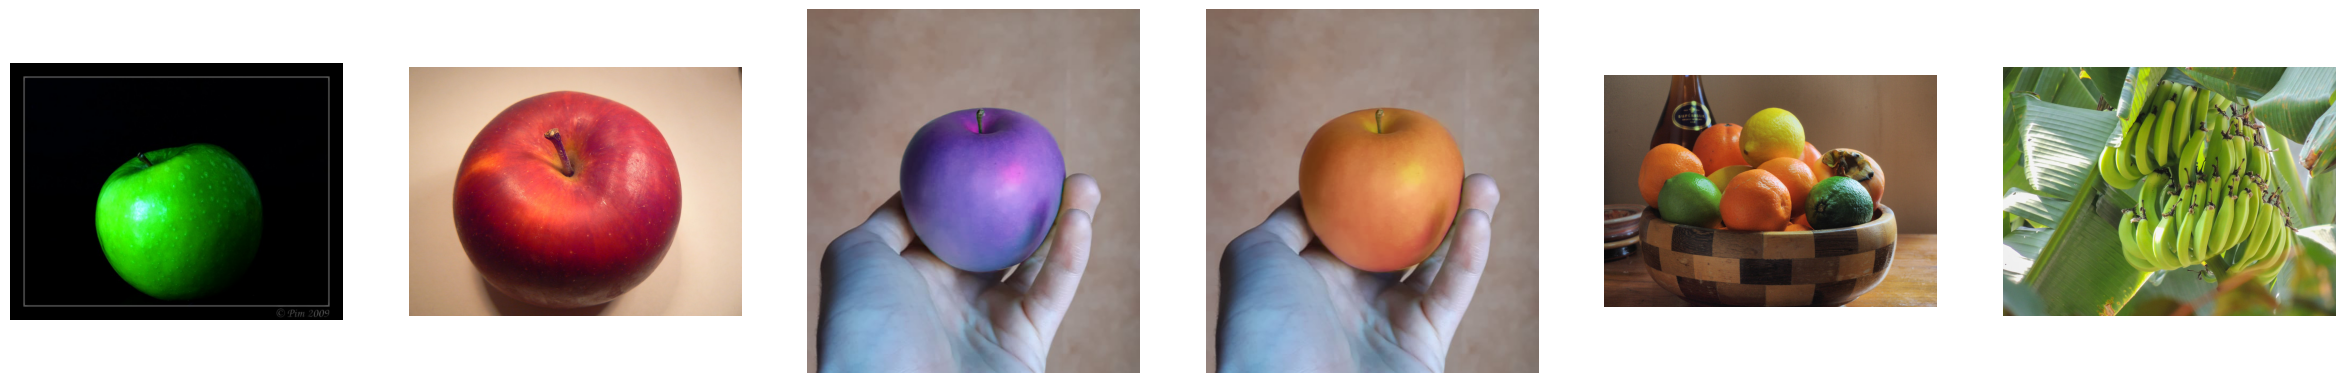

In [30]:
main_path = '/content/Multilingual-CLIP/Images/'
demo_images = {
    'Green Apple': 'green apple.jpg',
    'Red Apple': 'red apple.jpg',
    'Purple Apple': 'purple apple.png',
    'Orange Apple': 'Orange Apple.png',
    'Fruit Bowl': 'fruit bowl.jpg',
    'Bananas on Tree': 'bananas.jpg',
}
images = {name: Image.open(main_path + p) for name, p in demo_images.items()}

fig = plt.figure()
fig.set_size_inches(30,5)
for i, img in enumerate(images.values()):
  a=fig.add_subplot(1,len(images), i+1)
  plt.imshow(img, )
  plt.axis('off')

Creating Captions

In [31]:
hindi_captions = [
    'एक हरा सेब', 'एक लाल सेब', 'एक बैंगनी सेब', 'एक नारंगी सेब', 'एक फलों की थाली', 'एक पेड़ पर लटके हुए केले का गुच्छा'
]

russan_captions = [
    'Зеленое яблоко', 'Красное яблоко', 'Фиолетовое яблоко', 'Апельсиновое яблоко', 'Миска с фруктами', 'Гроздь бананов свисает с дерева'
]

french_captions = [
  'Une pomme verte', 'Une pomme rouge', 'Une pomme violette', 'Une pomme orange', 'Un bol rempli de fruits', 'Un tas de bananes pendu à un arbre'
]

german_captions = [
  'Ein grüner Apfel', 'Ein roter Apfel', 'Ein lila Apfel', 'Ein orangefarbener Apfel', 'Eine Schüssel voller Früchte', 'Ein Bündel Bananen hängt an einem Baum'
]

spanish_captions = [
    'Una manzana verde', 'Una manzana roja', 'Una manzana de color lila', 'Una manzana de color naranja', 'Un frutero lleno de fruta', 'Un racimo de bananas colgados de un banano',
]

greek_captions = [
    'Ένα πράσινο μήλο', 'Ένα κόκκινο μήλο', 'Ένα μοβ μήλο', 'Ένα πορτοκαλί μήλο', 'Ένα μπολ γεμάτο με φρούτα', 'Ένα τσαμπί μπανάνες κρεμάμενες από ένα δέντρο',
]

swedish_captions = [
  'Ett grönt äpple', 'Ett rött äpple', 'Ett lila äpple', 'Ett oranget äpple', 'En skål fylld med frukt', 'En klase bananer som hänger från ett träd'
]

all_captions = {'Hindi': hindi_captions,
                'Russian': russan_captions,
                'French': french_captions,
                'German': german_captions,
                'Spanish': spanish_captions,
                'Greek': greek_captions,
                'Swedish': swedish_captions
                }

Preparing image input for CLIP

In [33]:
img_input = torch.stack([compose(img).to('cpu') for img in images.values()])

# It iterates over each value in the images dictionary.
# For each image value, it applies the compose function to transform the image.
# It converts the transformed image tensor to CPU memory using .to('cpu').
# It stacks all the transformed and CPU converted image tensors into a single tensor using torch.stack().
# In summary, this line creates a batch of image tensors by applying a transformation (compose) to each image in the images dictionary and stacking the resulting tensors. This operation is commonly done in deep learning pipelines to prepare input data for processing by a neural network model.

In [36]:
with torch.no_grad():
    image_embs = clip_model.encode_image(img_input).float().to('cpu')

    language_embs = {}
    for lang, captions in all_captions.items():
      language_embs[lang] = text_model(captions)


print("CLIP-Vision: {}".format(image_embs.shape))
for lang, embs in language_embs.items():
  print("{}: {}".format(lang, embs.shape))

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument weight in method wrapper_CUDA___slow_conv2d_forward)

In [37]:
# Assuming img_input is your input image tensor
img_input = img_input.to('cuda:0')  # Move input to GPU

with torch.no_grad():
    image_embs = clip_model.encode_image(img_input).float().to('cpu')

language_embs = {}
for lang, captions in all_captions.items():
    language_embs[lang] = text_model(captions)

print("CLIP-Vision: {}".format(image_embs.shape))
for lang, embs in language_embs.items():
    print("{}: {}".format(lang, embs.shape))


CLIP-Vision: torch.Size([6, 640])
Hindi: torch.Size([6, 640])
Russian: torch.Size([6, 640])
French: torch.Size([6, 640])
German: torch.Size([6, 640])
Spanish: torch.Size([6, 640])
Greek: torch.Size([6, 640])
Swedish: torch.Size([6, 640])


In [38]:
def compare_embeddings(logit_scale, img_embs, txt_embs):
  # normalized features
  image_features = img_embs / img_embs.norm(dim=-1, keepdim=True)
  text_features = txt_embs / txt_embs.norm(dim=-1, keepdim=True)

  # cosine similarity as logits
  logits_per_image = logit_scale * image_features @ text_features.t()
  logits_per_text = logit_scale * text_features @ image_features.t()

  # shape = [global_batch_size, global_batch_size]
  return logits_per_image, logits_per_text

# CLIP Temperature scaler
logit_scale = clip_model.logit_scale.exp().float().to('cpu')

language_logits = {}
for lang, embs in language_embs.items():
  language_logits[lang] = compare_embeddings(logit_scale, image_embs, embs)

Language: Hindi


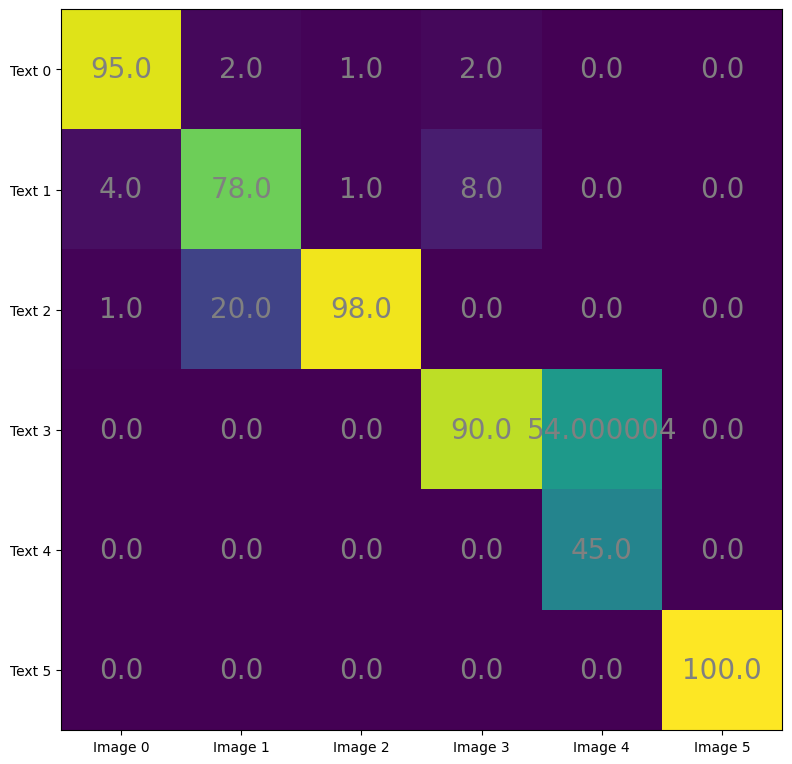

Language: Russian


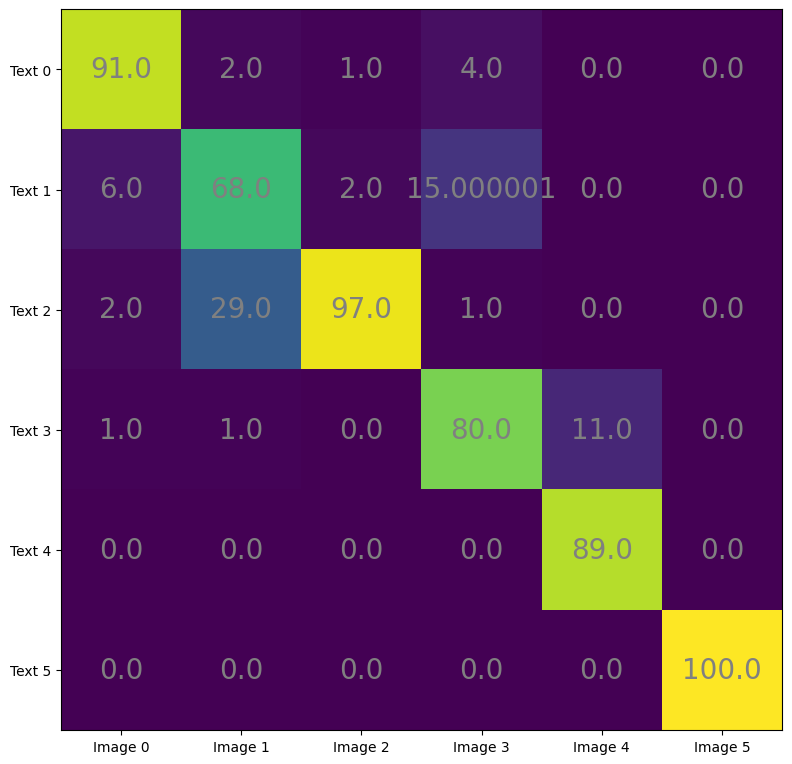

Language: French


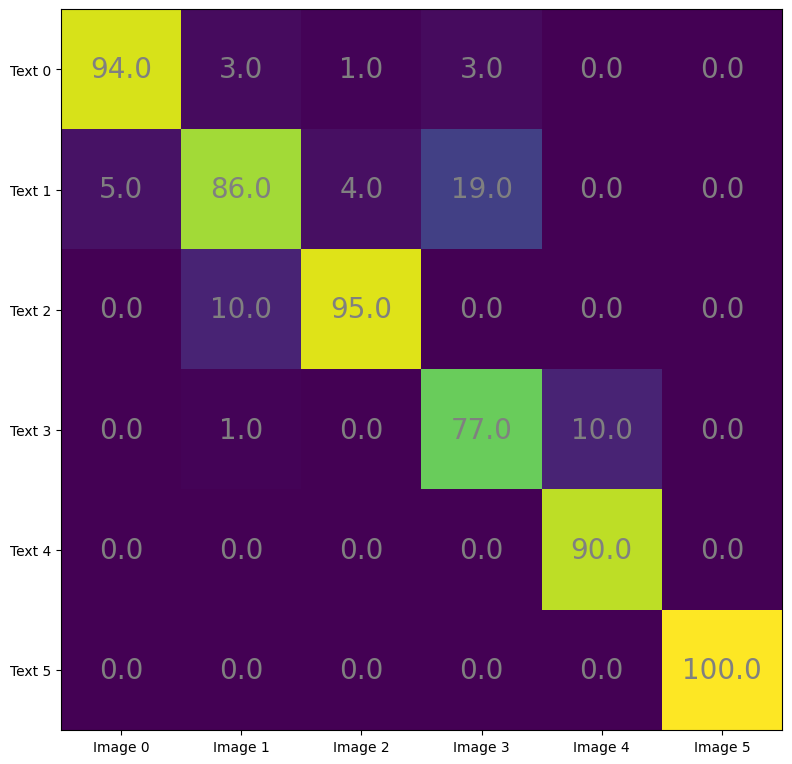

Language: German


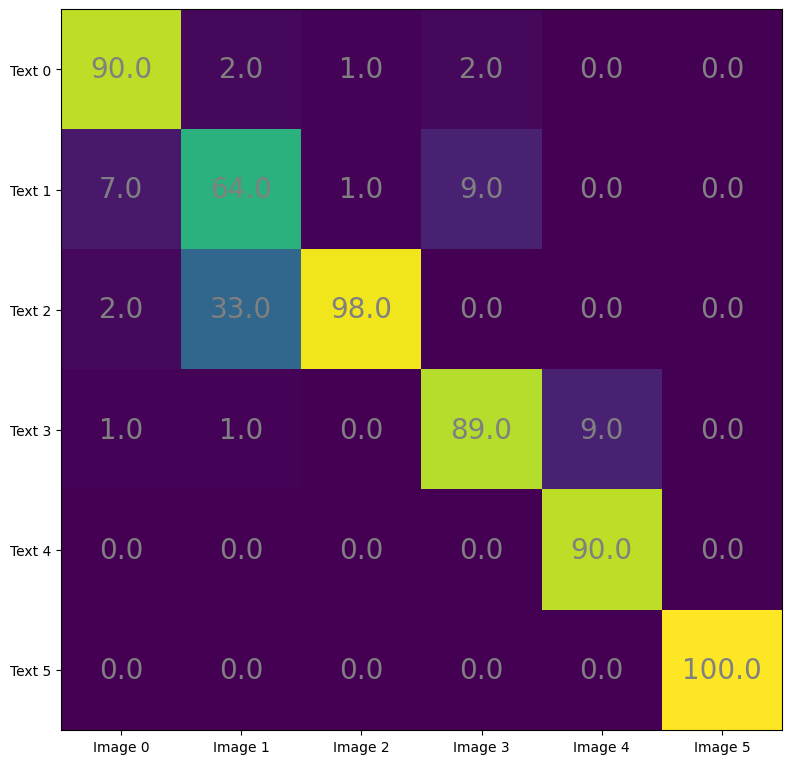

Language: Spanish


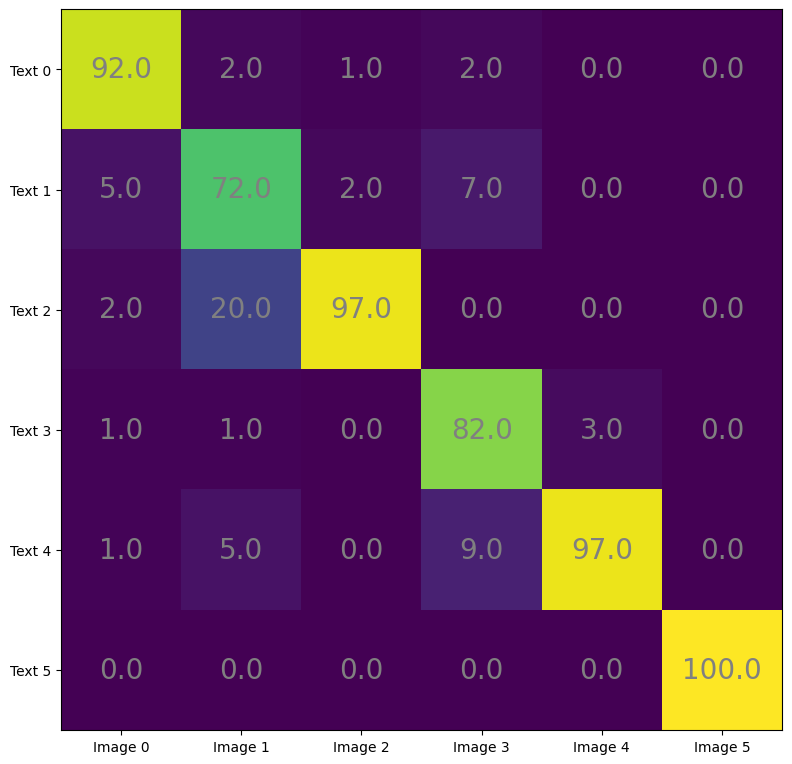

Language: Greek


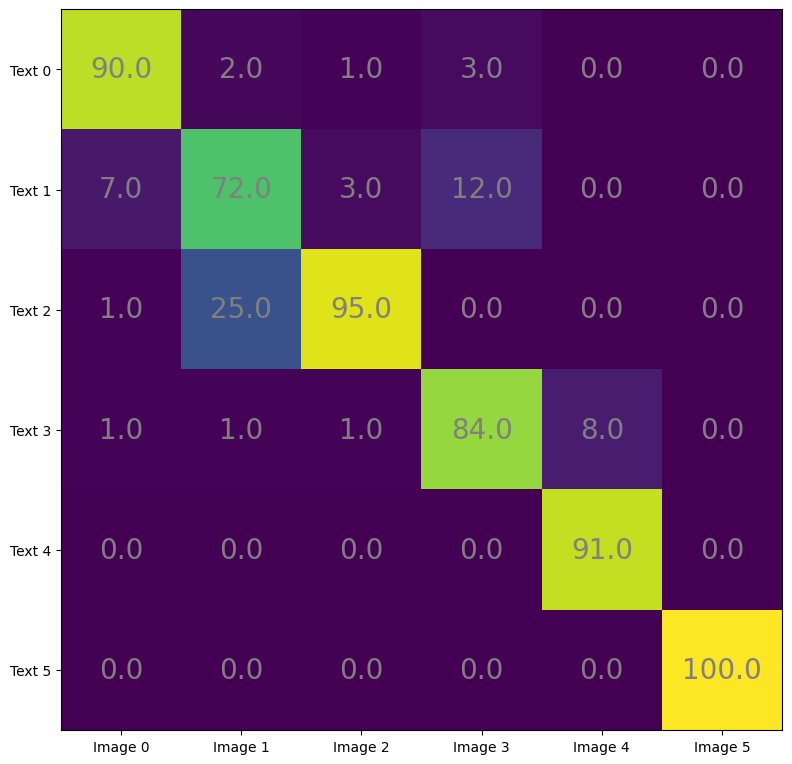

Language: Swedish


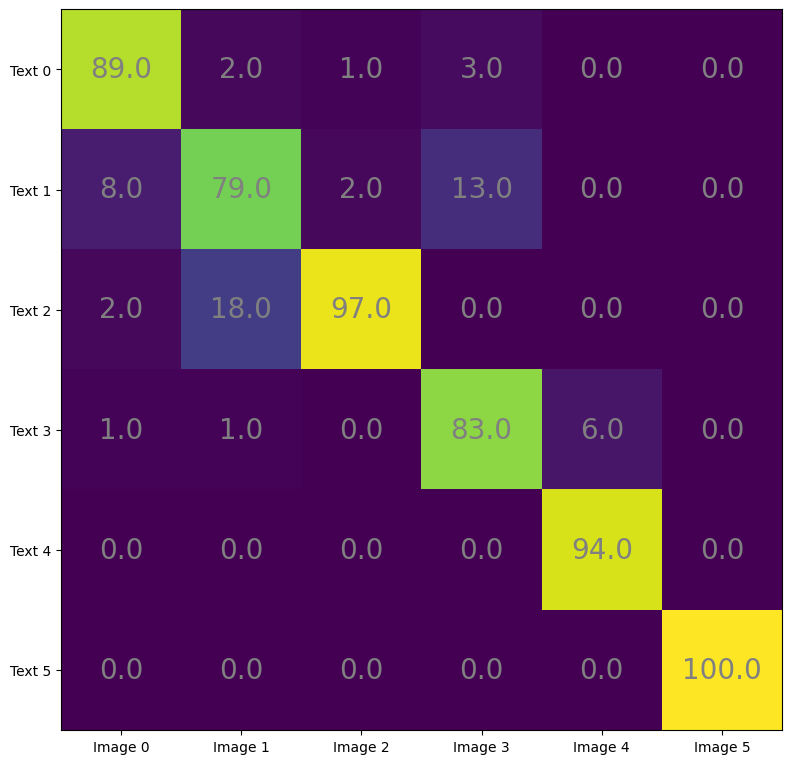

In [39]:
def plot_heatmap(result_matrix):
  height, width = result_matrix.shape
  fig, ax = plt.subplots()
  fig.set_size_inches(8,8)
  im = ax.imshow(result_matrix)



  # Create X & Y Labels
  ax.set_xticks(np.arange(width))
  ax.set_yticks(np.arange(height))
  ax.set_xticklabels(["Image {}".format(i) for i in range(width)])
  ax.set_yticklabels(["Text {}".format(i) for i in range(height)])

  for i in range(height):
    for j in range(width):
        text = ax.text(j, i, result_matrix[i, j],
                       ha="center", va="center", color='grey', size=20)

  fig.tight_layout()
  plt.show()

for lang, (img_logits, txt_logits) in language_logits.items():
  # Convert Logits into Softmax predictions
  probs = img_logits.softmax(dim=-1).cpu().detach().numpy()

  # Transpose so that each column is the softmax for each picture over the texts
  probs = np.around(probs, decimals=2).T * 100

  print("Language: {}".format(lang))
  plot_heatmap(probs)